In [1]:
import numpy as np
import torch
import gdown
import os
import zipfile  


if torch.cuda.is_available():
    print(f"✅ GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"🔥 Running on: {torch.device('cuda')}")
else:
    print("❌ GPU not available, using CPU.")


FILE_ID = "19MBh9JIJTxYIPAeO7G5RML5_ddjJ1Cpa"  
ZIP_PATH = "downloaded.zip" 
BASE_PATH = "../data/" 
PIXEL_CLOUD_PATH = os.path.join(BASE_PATH, "pixel_cloud/") 
SKOGSSTYRELSEN = os.path.join(BASE_PATH, "skogsstyrelsen-data/")  

def download_file():
    """Downloads the file from Google Drive if it doesn't exist."""
    if not os.path.exists(ZIP_PATH):
        print(f"📥 Downloading dataset to '{ZIP_PATH}'...")
        gdown.download(f"https://drive.google.com/uc?export=download&id={FILE_ID}", ZIP_PATH, quiet=False)
        print("✅ Download complete!")
    else:
        print(f"✅ File '{ZIP_PATH}' already exists. Skipping download.")

def extract_zip():
    """Extracts the ZIP file into the respective folders and deletes the ZIP file after extraction."""

    if not os.path.exists(ZIP_PATH):
        print(f"❌ Error: '{ZIP_PATH}' not found. Cannot extract.")
        return

    if not zipfile.is_zipfile(ZIP_PATH):
        print("❌ Error: The downloaded file is not a valid ZIP archive.")
        return

    print(f"📂 Extracting '{ZIP_PATH}' into '{BASE_PATH}'...")
    

    os.makedirs(PIXEL_CLOUD_PATH, exist_ok=True)

    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(BASE_PATH)

    print("✅ Extraction complete!")
    os.remove(ZIP_PATH)
    print(f"🗑️ Deleted ZIP file '{ZIP_PATH}' after extraction.")

def list_files():
    """Lists extracted files for verification."""
    print("\n📁 Extracted files in CLOUD_PATH:")
    for root, dirs, files in os.walk(SKOGSSTYRELSEN):
        for file in files:
            print(f" - {os.path.join(root, file)}")

    print("\n📁 Extracted files in PIXEL_CLOUD_PATH:")
    for root, dirs, files in os.walk(PIXEL_CLOUD_PATH):
        for file in files:
            print(f" - {os.path.join(root, file)}")


download_file()
extract_zip()
list_files()



✅ GPU is available: NVIDIA GeForce GTX 1080
🔥 Running on: cuda
📥 Downloading dataset to 'downloaded.zip'...


Downloading...
From: https://drive.google.com/uc?export=download&id=19MBh9JIJTxYIPAeO7G5RML5_ddjJ1Cpa
To: /home/irregular/d7046e_ann_project/notebooks/downloaded.zip
100%|██████████| 4.79M/4.79M [00:00<00:00, 12.5MB/s]


✅ Download complete!
📂 Extracting 'downloaded.zip' into '../data/'...
✅ Extraction complete!
🗑️ Deleted ZIP file 'downloaded.zip' after extraction.

📁 Extracted files in CLOUD_PATH:
 - ../data/skogsstyrelsen-data/skogs_json_val.npy
 - ../data/skogsstyrelsen-data/skogs_gts_val.npy
 - ../data/skogsstyrelsen-data/skogs_gts_test.npy
 - ../data/skogsstyrelsen-data/skogs_names_train.npy
 - ../data/skogsstyrelsen-data/skogs_names_test.npy
 - ../data/skogsstyrelsen-data/skogs_gts_train.npy
 - ../data/skogsstyrelsen-data/skogs_json_test.npy
 - ../data/skogsstyrelsen-data/skogs_json_train.npy
 - ../data/skogsstyrelsen-data/skogs_names_val.npy
 - ../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_910d1b98-44c7-ed11-9174-005056a6f472.nc
 - ../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_db7d323a-3fc7-ed11-9174-005056a6f472.nc
 - ../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_dd360cea-43c7-ed11-9174-005056a6f472.nc
 - ../data/skogsstyrelsen-data/2A-netcdfs

In [ ]:
import os
import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
import xarray as xr


DATA_PATH = "../data/skogsstyrelsen-data/"
BAND_NAMES = ['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b8a', 'b09', 'b11', 'b12']
IMAGE_SIZE = 20  # Fixed size for CNN

def load_npy_data(split):
    """Load file names and labels for a given dataset split."""
    file_names = np.load(os.path.join(DATA_PATH, f"skogs_names_{split}.npy"), allow_pickle=True)
    labels = np.load(os.path.join(DATA_PATH, f"skogs_gts_{split}.npy"), allow_pickle=True)
    labels = labels.astype(np.float32)  
    return file_names, labels

class SkogsDataset(Dataset):
    def __init__(self, split="train"):
        self.file_names, self.labels = load_npy_data(split)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = self.file_names[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0) 

        image = torch.zeros((12, IMAGE_SIZE, IMAGE_SIZE), dtype=torch.float32)
        nc_file = os.path.join(DATA_PATH, "2A-netcdfs-cropped-from-nuria", os.path.basename(img_path))

        if os.path.exists(nc_file):
            with xr.open_dataset(nc_file, engine="netcdf4") as ds:
                band_list = [(ds[band].values.squeeze() - 1000) / 10000 for band in BAND_NAMES]
                band_list_fixed = [torch.tensor(band[:IMAGE_SIZE, :IMAGE_SIZE], dtype=torch.float32) for band in band_list]
                image = torch.stack(band_list_fixed)

        return {"image": image, "label": label}


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

train_dataset = SkogsDataset("train")
val_dataset = SkogsDataset("val")
test_dataset = SkogsDataset("test")  

trds = len(train_dataset)
vds = len(val_dataset)
tds = len(test_dataset) 
sds = trds+vds+tds
print(f"{trds/sds:.2%}, {vds/sds:.2%} , {tds/sds:.2%}" ) 

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)  
 

60.19%, 16.67% , 23.15%


In [ ]:
class CNN_CloudClassifier(nn.Module):
    def __init__(self):
        super(CNN_CloudClassifier, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128*2*2, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(50,1),
            nn.Sigmoid()
        ) 
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layers(x)
        return x


In [ ]:
DEVICE = 'cuda'
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return total_loss / len(dataloader)

In [9]:
LR=1e-3
def train_model(model, train_loader, val_loader, epochs=25, lr=1e-3):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(DEVICE)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train() 
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            images = batch["image"].to(DEVICE)  
            labels = batch["label"].to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = evaluate_model(model, val_loader)

        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | LR: {lr} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses


In [14]:
model = CNN_CloudClassifier().to(DEVICE)

train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=25)


Accuracy: 72.22%
Epoch 1/25 | LR: 0.001 | Train Loss: 0.6465 | Val Loss: 0.6300
Accuracy: 72.22%
Epoch 2/25 | LR: 0.001 | Train Loss: 0.5783 | Val Loss: 0.6007
Accuracy: 73.61%
Epoch 3/25 | LR: 0.001 | Train Loss: 0.5330 | Val Loss: 0.5716
Accuracy: 72.22%
Epoch 4/25 | LR: 0.001 | Train Loss: 0.4650 | Val Loss: 0.6586
Accuracy: 65.28%
Epoch 5/25 | LR: 0.001 | Train Loss: 0.5048 | Val Loss: 0.5703
Accuracy: 75.00%
Epoch 6/25 | LR: 0.001 | Train Loss: 0.4336 | Val Loss: 0.5994
Accuracy: 76.39%
Epoch 7/25 | LR: 0.001 | Train Loss: 0.4591 | Val Loss: 0.4982
Accuracy: 81.94%
Epoch 8/25 | LR: 0.001 | Train Loss: 0.4149 | Val Loss: 0.5272
Accuracy: 80.56%
Epoch 9/25 | LR: 0.001 | Train Loss: 0.4049 | Val Loss: 0.4889
Accuracy: 80.56%
Epoch 10/25 | LR: 0.001 | Train Loss: 0.3996 | Val Loss: 0.4806
Accuracy: 80.56%
Epoch 11/25 | LR: 0.001 | Train Loss: 0.4006 | Val Loss: 0.4887
Accuracy: 83.33%
Epoch 12/25 | LR: 0.001 | Train Loss: 0.3987 | Val Loss: 0.4613
Accuracy: 80.56%
Epoch 13/25 | LR: 0.

Accuracy: 86.00%
0.37008480727672577


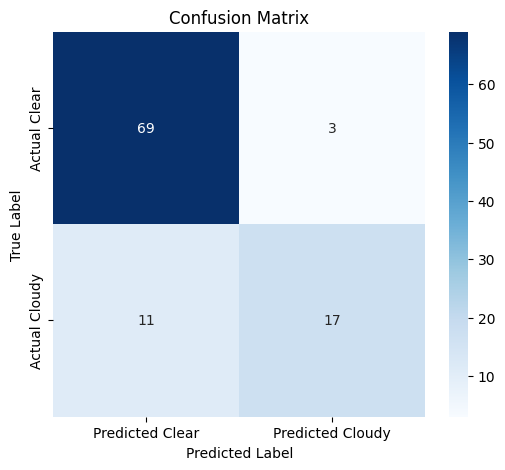

Classification Report:
              precision    recall  f1-score   support

       Clear       0.86      0.96      0.91        72
      Cloudy       0.85      0.61      0.71        28

    accuracy                           0.86       100
   macro avg       0.86      0.78      0.81       100
weighted avg       0.86      0.86      0.85       100



In [ ]:
print(evaluate_model(model, test_loader))

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(DEVICE)
        labels = batch["label"].cpu().numpy() 
        outputs = model(images)
        predicted = (outputs.cpu().numpy() > 0.5).astype(int) 
        true_labels.extend(labels)
        predicted_labels.extend(predicted)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Predicted Clear', 'Predicted Cloudy'],
            yticklabels=['Actual Clear', 'Actual Cloudy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Clear', 'Cloudy']))
